<a href="https://colab.research.google.com/github/CoffeeAddict2109/TimeSeries-Electric-Production-with-LSTM/blob/main/Time_Series_Electric_Production_with_LSTM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Modul Standar

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")


In [ ]:
df = pd.read_csv('/content/sample_data/Electric_Production.csv')
df.head(10)

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151
5,06-01-1985,58.0904
6,07-01-1985,62.6202
7,08-01-1985,63.2485
8,09-01-1985,60.5846
9,10-01-1985,56.3154


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    397 non-null    object 
 1   Value   397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [ ]:
# merubah tipe data object to datetime
df['DATE'] = df['DATE'].astype('datetime64')

# melihat tipe data dataframe
print(df.dtypes)


DATE     datetime64[ns]
Value           float64
dtype: object


In [ ]:
print('waktu terawal dari kolom Datetime adalah:', df['DATE'].min())
df.head()


waktu terawal dari kolom Datetime adalah: 1985-01-01 00:00:00


,DATE,Value
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


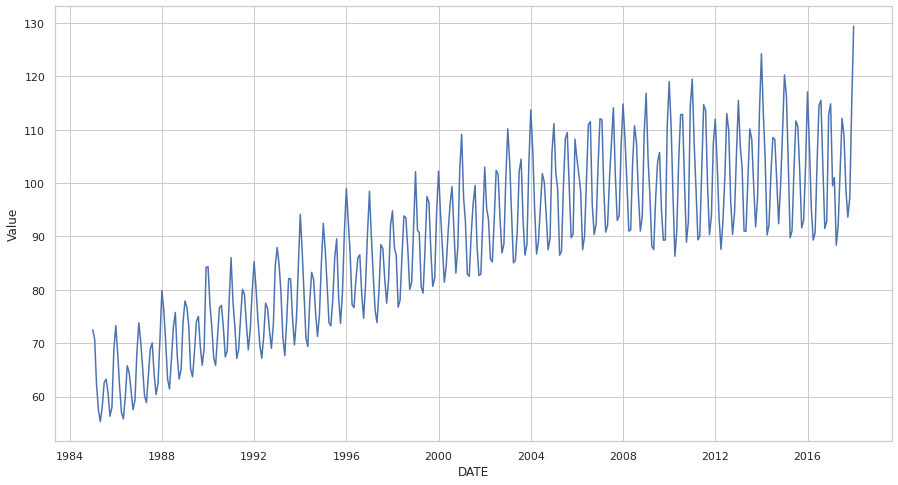

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df, x='DATE', y='Value')


In [ ]:
#df1 = df[-5*20:].reset_index(drop=True)
#df1


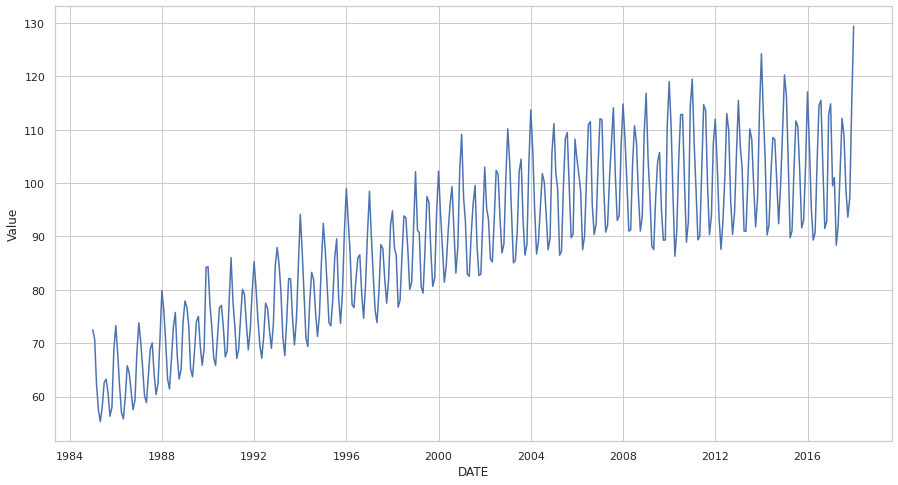

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df, x='DATE', y='Value')


In [ ]:
df.describe()


,Value
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


### Split Data



In [ ]:
# split data
train_size = int(len(df) * 0.6) # Menentukan banyaknya data train yaitu sebesar 70% data
train = df[:train_size]
test =df[train_size:].reset_index(drop=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train[['Value']])

train['scaled'] = scaler.transform(train[['Value']])
test['scaled'] = scaler.transform(test[['Value']])

In [ ]:
train.head()


,DATE,Value,scaled
0,1985-01-01,72.5052,0.294313
1,1985-02-01,70.6720,0.262927
2,1985-03-01,62.4502,0.122161
3,1985-04-01,57.4714,0.036918
4,1985-05-01,55.3151,0.000000


In [ ]:
def sliding_window(data, window_size):
    sub_seq, next_values = [], []
    for i in range(len(data)-window_size):
        sub_seq.append(data[i:i+window_size])
        next_values.append(data[i+window_size])
    X = np.stack(sub_seq)
    y = np.array(next_values)
    return X,y


In [ ]:
window_size = 7

X_train, y_train = sliding_window(train[['scaled']].values, window_size)
X_test, y_test = sliding_window(test[['scaled']].values, window_size)


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(231, 7, 1) (231, 1)
(152, 7, 1) (152, 1)


# Modelling

# Import Modul

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM  

In [ ]:
def create_model(LSTM_unit=64, dropout=0.2): #jika ingin menggunakan RNN atau GRU ganti LSTM dengan GRU/RNN
    # create model
    model = Sequential()
    model.add(LSTM(units=LSTM_unit, input_shape=(window_size, 1)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

# Membuat Model



In [ ]:
LSTM_unit = [16,32,64,128]
dropout = [0.1,0.2]


In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
# Early Stopping
es = EarlyStopping(monitor = 'val_loss', mode = "min", patience = 5, verbose = 0)

# create model
model = KerasRegressor(build_fn=create_model, epochs=50, validation_split=0.1, batch_size=32, callbacks=[es], verbose=1)

# define the grid search parameters
LSTM_unit = [16,32,64,128]
dropout=[0.1,0.2]
param_grid = dict(LSTM_unit=LSTM_unit, dropout=dropout)

# Membuat Variabel GridSearchCV


In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)

# Training Model dengan GridSearchCV



In [ ]:
grid_result = grid.fit(X_train, y_train)

Epoch 1/50
7/7 [==============================] - 3s 96ms/step - loss: 0.1383 - mae: 0.3225 - val_loss: 0.1355 - val_mae: 0.3400
Epoch 2/50
7/7 [==============================] - 0s 9ms/step - loss: 0.0281 - mae: 0.1324 - val_loss: 0.0359 - val_mae: 0.1597
Epoch 3/50
7/7 [==============================] - 0s 9ms/step - loss: 0.0281 - mae: 0.1441 - val_loss: 0.0254 - val_mae: 0.1253
Epoch 4/50
7/7 [==============================] - 0s 9ms/step - loss: 0.0183 - mae: 0.1102 - val_loss: 0.0401 - val_mae: 0.1551
Epoch 5/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0205 - mae: 0.1138 - val_loss: 0.0222 - val_mae: 0.1194
Epoch 6/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0173 - mae: 0.1102 - val_loss: 0.0208 - val_mae: 0.1236
Epoch 7/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0161 - mae: 0.1064 - val_loss: 0.0272 - val_mae: 0.1275
Epoch 8/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0171 - mae: 0.1044 - val_lo

# Melihat Hasil Parameter Terbaik


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Mengambil model terbaik
best_model = grid_result.best_estimator_.model

Best: -0.014019 using {'LSTM_unit': 128, 'dropout': 0.1}
-0.022155 (0.010176) with: {'LSTM_unit': 16, 'dropout': 0.1}
-0.023182 (0.012014) with: {'LSTM_unit': 16, 'dropout': 0.2}
-0.017584 (0.005939) with: {'LSTM_unit': 32, 'dropout': 0.1}
-0.017956 (0.004410) with: {'LSTM_unit': 32, 'dropout': 0.2}
-0.015740 (0.005798) with: {'LSTM_unit': 64, 'dropout': 0.1}
-0.016124 (0.003796) with: {'LSTM_unit': 64, 'dropout': 0.2}
-0.014019 (0.004543) with: {'LSTM_unit': 128, 'dropout': 0.1}
-0.015011 (0.002693) with: {'LSTM_unit': 128, 'dropout': 0.2}


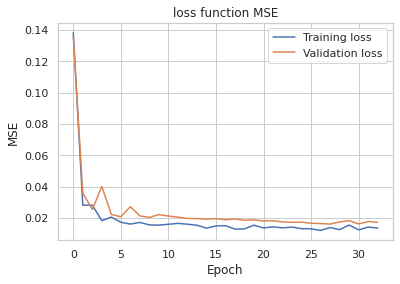

In [ ]:
history = best_model.history
# grafik loss function MSE

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('loss function MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()

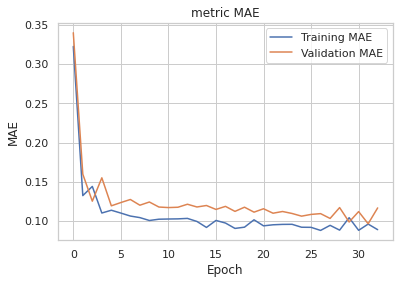

In [ ]:
# grafik metric MAE

plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('metric MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

# Evaluasi Model


In [ ]:
# Prediksi data train
predict_train = scaler.inverse_transform(best_model.predict(X_train))
true_train = scaler.inverse_transform(y_train)

# Prediksi data test
predict_test = scaler.inverse_transform(best_model.predict(X_test))
true_test = scaler.inverse_transform(y_test)

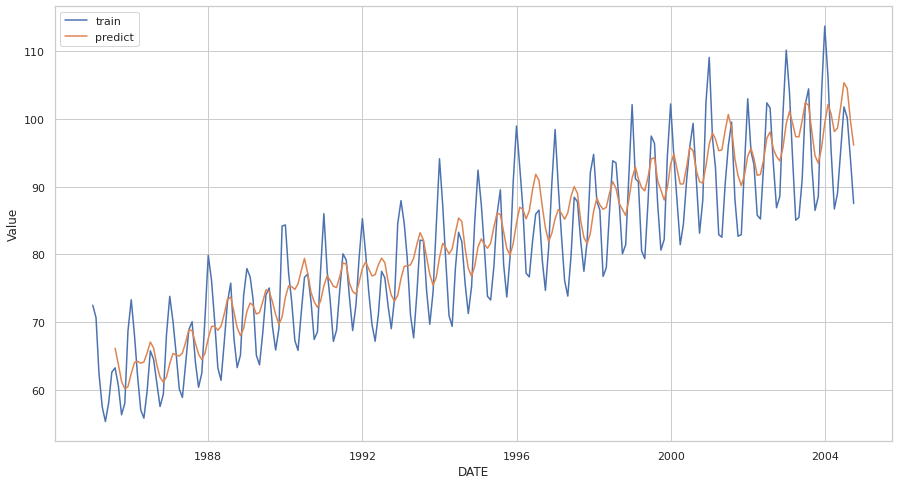

In [ ]:
train['predict'] = np.nan
train['predict'][-len(predict_train):] = predict_train[:,0]

plt.figure(figsize=(15,8))
sns.lineplot(data=train, x='DATE', y='Value', label = 'train')
sns.lineplot(data=train, x='DATE', y='predict', label = 'predict')

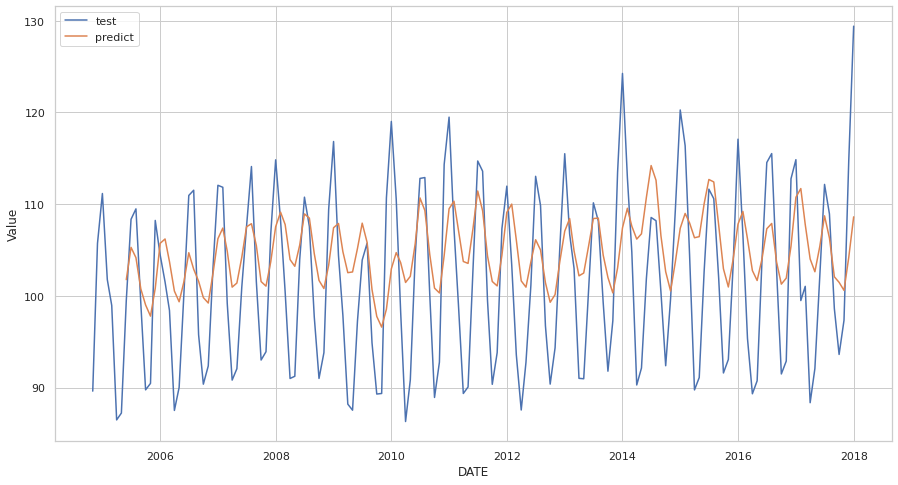

In [ ]:
test['predict'] = np.nan
test['predict'][-len(predict_test):] = predict_test[:,0]

plt.figure(figsize=(15,8))
sns.lineplot(data=test, x='DATE', y='Value', label = 'test')
sns.lineplot(data=test, x='DATE', y='predict', label = 'predict')

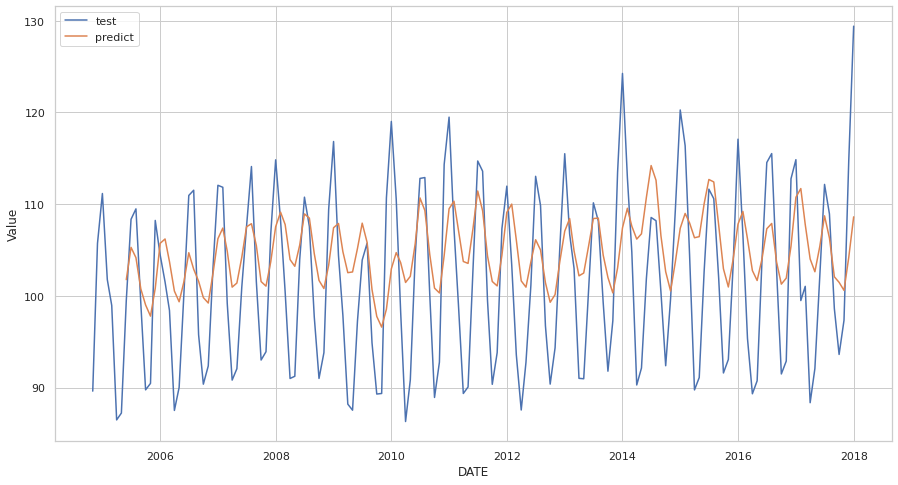

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(data=test, x='DATE', y='Value', label = 'test')
sns.lineplot(data=test, x='DATE', y='predict', label = 'predict')

Melakukan forecasting

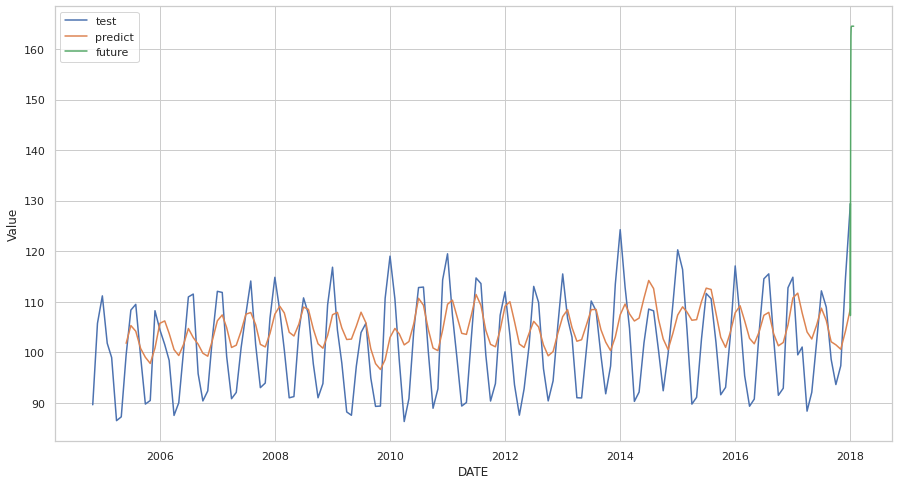

In [ ]:
# forecasting data selanjutnya
y_test = scaler.transform(test[['Value']])
n_future = 500
future = [[y_test[-1,0]]]
X_new = y_test[-window_size:,0].tolist()

for i in range(n_future):
    y_future = best_model.predict(np.array([X_new]).reshape(1,window_size,1))
    future.append([y_future[0,0]])
    X_new = X_new[1:]
    X_new.append(y_future[0,0])

future = scaler.inverse_transform(np.array(future))
date_future = pd.date_range(start=test['DATE'].values[-1], periods=n_future+1, freq='H')
# Plot Data sebulan terakhir dan seminggu ke depan
plt.figure(figsize=(15,8))
sns.lineplot(data=test, x='DATE', y='Value', label = 'test')
sns.lineplot(data=test, x='DATE', y='predict', label = 'predict')
sns.lineplot(x=date_future, y=future[:,0], label = 'future')
plt.ylabel('Value');
